In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/frauds/Fraud.csv


In [1]:
# Note : In The middle of the codes as well as at last section of this notebook there are some key points answering the following questions :
# 1. Data cleaning including missing values, outliers and multi-collinearity.
# 2. Describe your fraud detection model in elaboration.
# 3. How did you select variables to be included in the model?
# 4. Demonstrate the performance of the model by using best set of tools.
# 5. What are the key factors that predict fraudulent customer?
# 6. Do these factors make sense? If yes, How? If not, How not?
# 7. What kind of prevention should be adopted while company update its infrastructure?
# 8. Assuming these actions have been implemented, how would you determine if they work?

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
from scipy.stats import iqr
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, f1_score, f1_score, precision_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
sns.set(style="whitegrid")

In [4]:
df = pd.read_csv('/kaggle/input/frauds/Fraud.csv')

In [5]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# •	There are several steps for data cleaning and preprocessing:
# 	Missing values: The checks for missing values is done using df.isna().sum(), However in the current Fraud dataset there are no missing values.
# 	Outliers: The box plots and log transformation is used to handle outliers in numeric columns. It also calculates the Interquartile Range (IQR) for each numeric column, which can be used to identify outliers.
# 	Multi-collinearity: A correlation heatmap is created to visualize the relationships between numeric variables. This helps identify potential multi-collinearity issues.


In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [8]:
df = df.rename(columns={'newbalanceOrig': 'newbalanceOrg', 'nameOrig': 'nameOrg'})
df.isna().sum()

step              0
type              0
amount            0
nameOrg           0
oldbalanceOrg     0
newbalanceOrg     0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows:,}")
print("Number of columns:", num_columns)

Number of rows: 6,362,620
Number of columns: 11


In [10]:
#Define custom colors
light_orange = '#ffd699'
light_red = '#ff9999'

In [11]:
unique_types = df['type'].unique();
type_counts = df['type'].value_counts()

num_unique_types = len(unique_types)
print(type_counts)

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


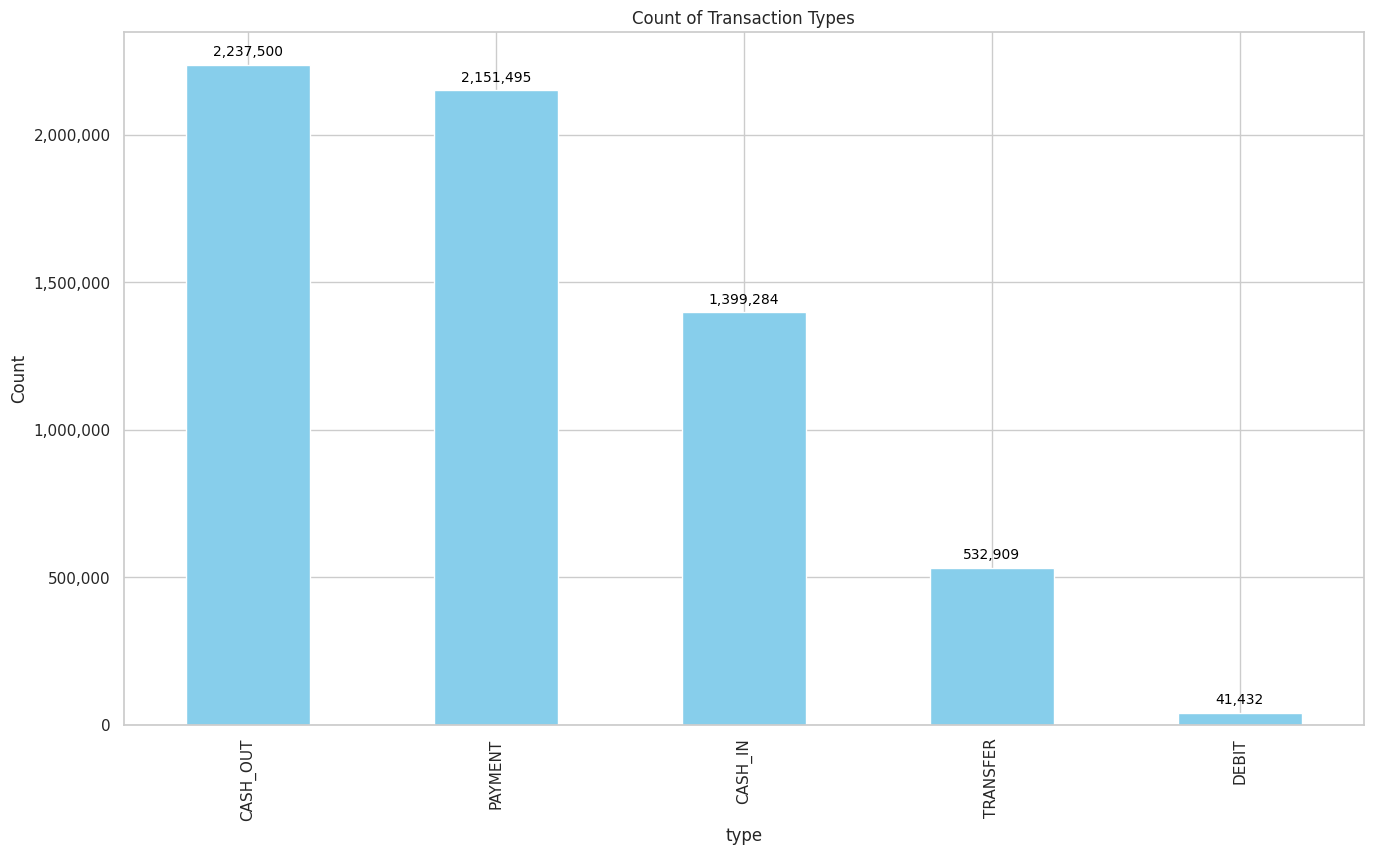

In [12]:
plt.figure(figsize=(16, 9))
plt.title('Count of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
bars = type_counts.plot(kind='bar', color='skyblue')

# Add data labels on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20000, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10, color='black')

# Format count axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))
plt.show()

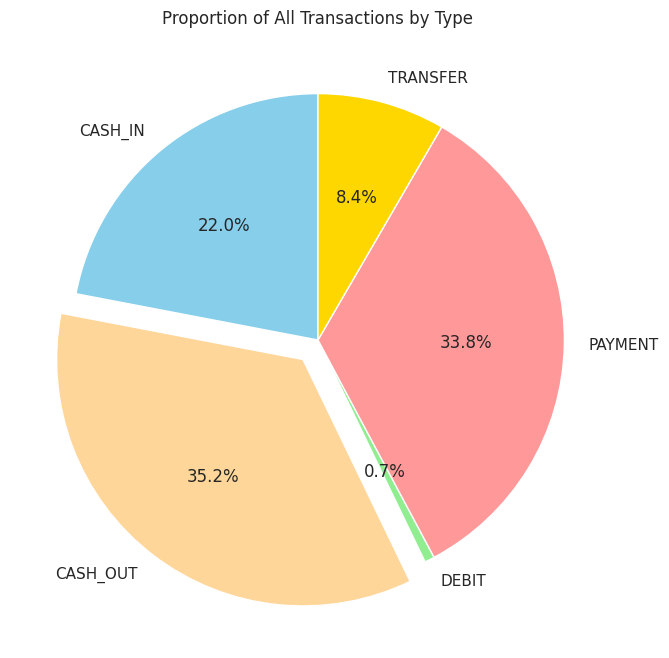

In [13]:
all_counts_by_type = df.groupby("type").size()
plt.figure(figsize=(8, 8))
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', light_orange, 'lightgreen', light_red, 'gold'], explode=(0, 0.1, 0, 0, 0))
plt.title('Proportion of All Transactions by Type')
plt.show()

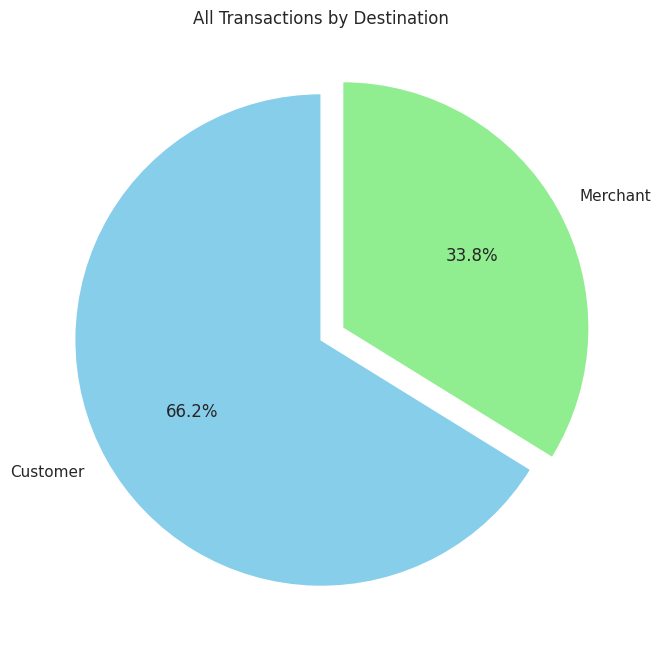

In [14]:
df_copy = df.copy();
df_copy['nameDest_first_letter'] = df_copy['nameDest'].str[0]
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('C', 'Customer')
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('M', 'Merchant')
all_by_dest = df_copy.groupby('nameDest_first_letter').size()

plt.figure(figsize=(8, 8))
plt.pie(all_by_dest, labels=all_by_dest.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'], explode=(0, 0.1))
plt.title('All Transactions by Destination')
plt.show()

In [15]:
fraud_count = df[df["isFraud"] == 1].shape[0]
non_fraud_count = df[df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraud_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraud_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


In [16]:
total_transactions = fraud_count + non_fraud_count

fraud_percentage = (fraud_count / total_transactions) * 100
non_fraud_percentage = (non_fraud_count / total_transactions) * 100

print(f"Fraud Transactions percentage: {fraud_percentage:.2f}%")
print(f"Non-fraud Transactions percentage: {non_fraud_percentage:.2f}%")

Fraud Transactions percentage: 0.13%
Non-fraud Transactions percentage: 99.87%


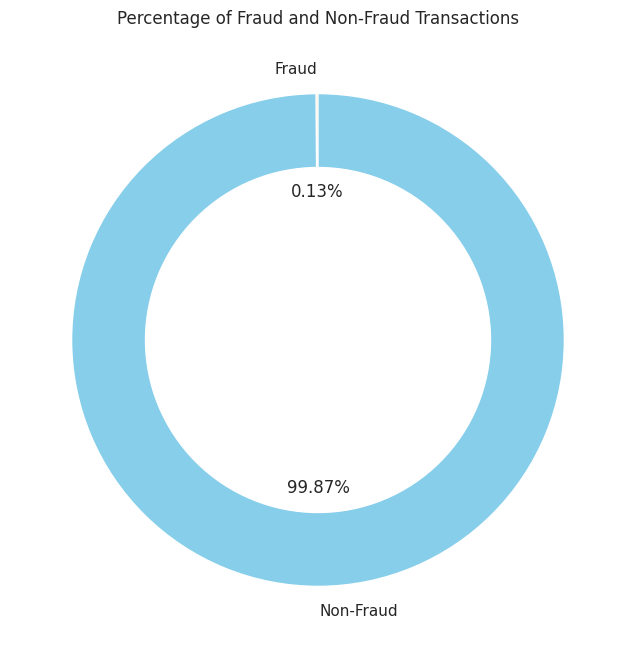

In [17]:
labels = ['Fraud', 'Non-Fraud']
sizes = [fraud_percentage, non_fraud_percentage]
colors = ['orange', 'skyblue']

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Percentage of Fraud and Non-Fraud Transactions')
plt.show()

type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


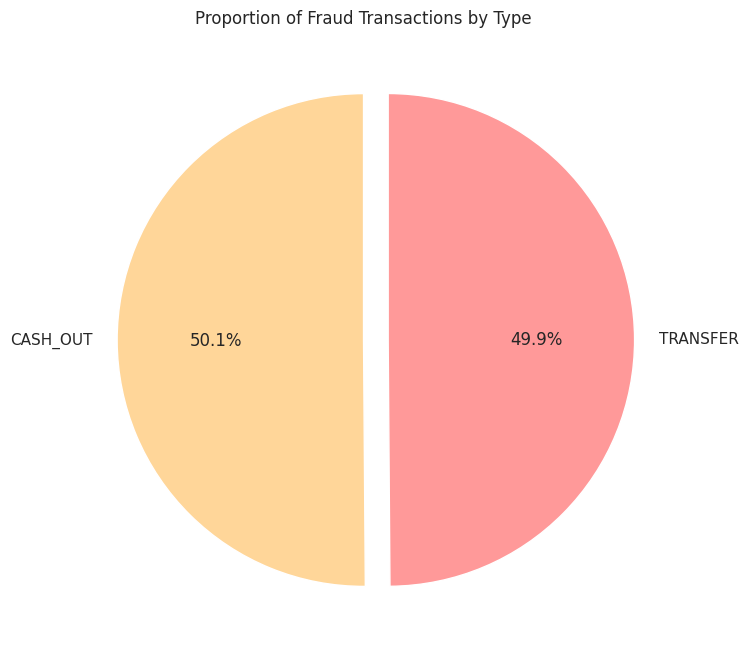

In [18]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_counts_by_type = fraud_transactions.groupby("type").size()
print(fraud_counts_by_type)

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts_by_type, labels=fraud_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Proportion of Fraud Transactions by Type')
plt.show()

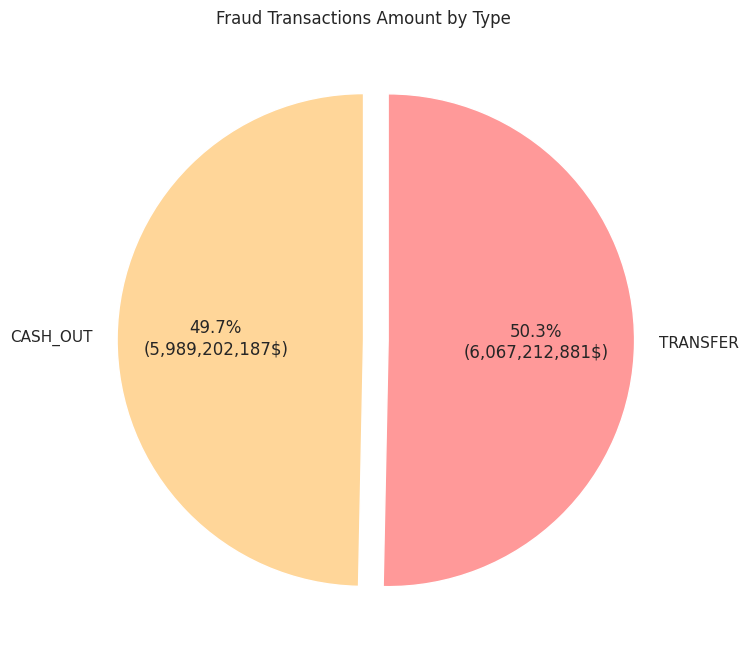

In [19]:
fraud_amounts_by_type = df[df["isFraud"] == 1].groupby("type")["amount"].sum()
plt.figure(figsize=(8, 8))
plt.pie(fraud_amounts_by_type, labels=fraud_amounts_by_type.index, autopct=lambda p: f'{p:.1f}%\n({p * sum(fraud_amounts_by_type) / 100:,.0f}$)', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Fraud Transactions Amount by Type')
plt.show()

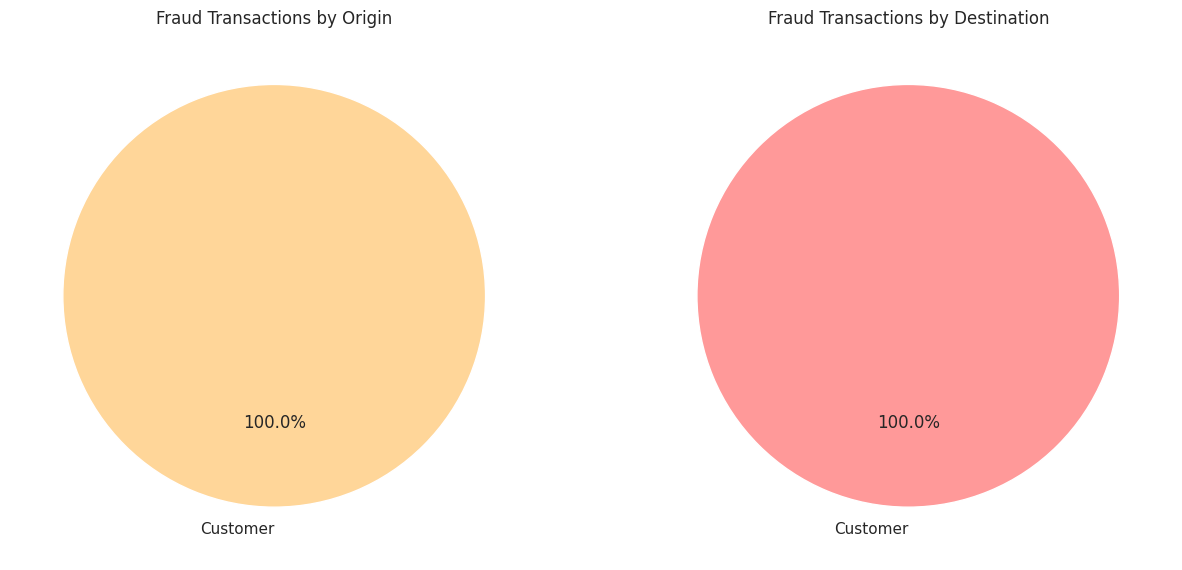

In [20]:
fraud_transactions = df[df['isFraud'] == 1].copy()
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg'].str[0]
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest'].str[0]
fraud_transactions['nameOrg_first_letter'] = fraud_transactions['nameOrg_first_letter'].replace('C', 'Customer')
fraud_transactions['nameDest_first_letter'] = fraud_transactions['nameDest_first_letter'].replace('C', 'Customer')
fraud_by_name_orig_first_letter = fraud_transactions.groupby('nameOrg_first_letter').size()
fraud_by_name_dest_first_letter = fraud_transactions.groupby('nameDest_first_letter').size()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].pie(fraud_by_name_orig_first_letter, labels=fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange])
axes[0].set_title('Fraud Transactions by Origin')

axes[1].pie(fraud_by_name_dest_first_letter, labels=fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_red])
axes[1].set_title('Fraud Transactions by Destination')

plt.show()

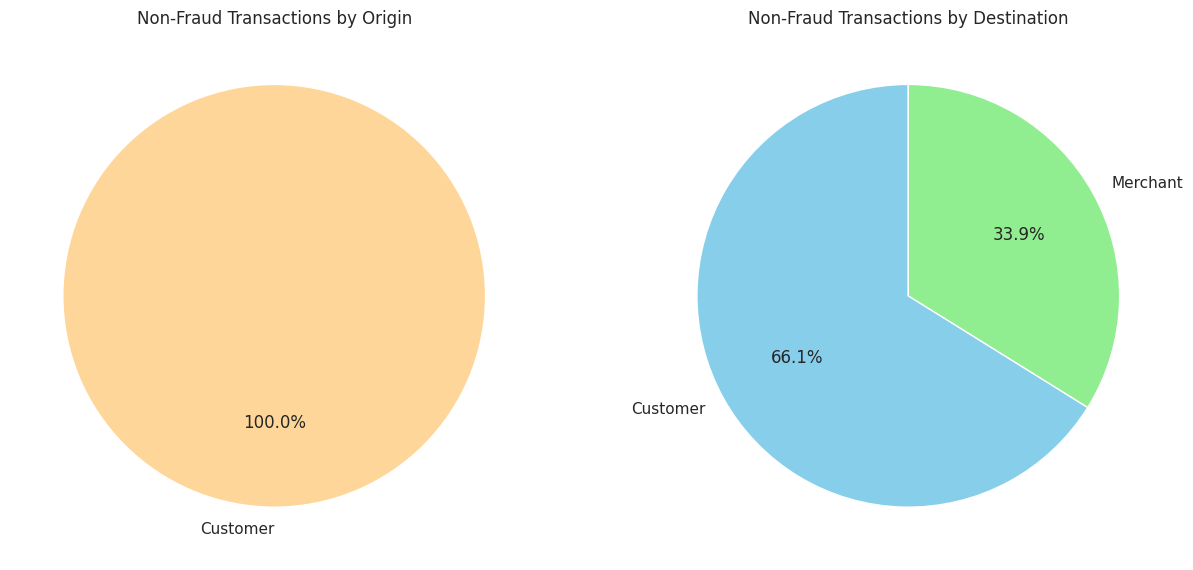

In [21]:
non_fraud_transactions = df[df['isFraud'] == 0].copy()
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg'].str[0]
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest'].str[0]
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})

non_fraud_by_name_orig_first_letter = non_fraud_transactions.groupby('nameOrg_first_letter').size()
non_fraud_by_name_dest_first_letter = non_fraud_transactions.groupby('nameDest_first_letter').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Pie chart for Non-Fraud Transactions by Origin
axes[0].pie(non_fraud_by_name_orig_first_letter, labels=non_fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, 'lightcoral'])
axes[0].set_title('Non-Fraud Transactions by Origin')

# Pie chart for Non-Fraud Transactions by Destination
axes[1].pie(non_fraud_by_name_dest_first_letter, labels=non_fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[1].set_title('Non-Fraud Transactions by Destination')

plt.show()

In [22]:
pd.set_option('display.float_format', '{:,.2f}'.format)
print("Statistics on the amounts for non-fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 0].amount), "\n")
print("Statistics on the amounts for fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 1].amount), "\n")

Statistics on the amounts for non-fraud transactions:
 count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: amount, dtype: float64 

Statistics on the amounts for fraud transactions:
 count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


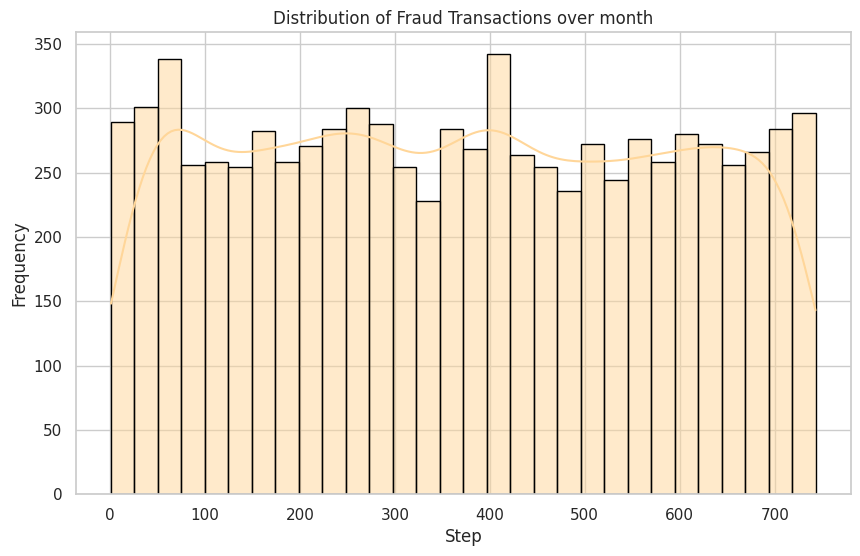

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_transactions["step"], bins=30, kde=True, color=light_orange, edgecolor='black')
plt.title('Distribution of Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


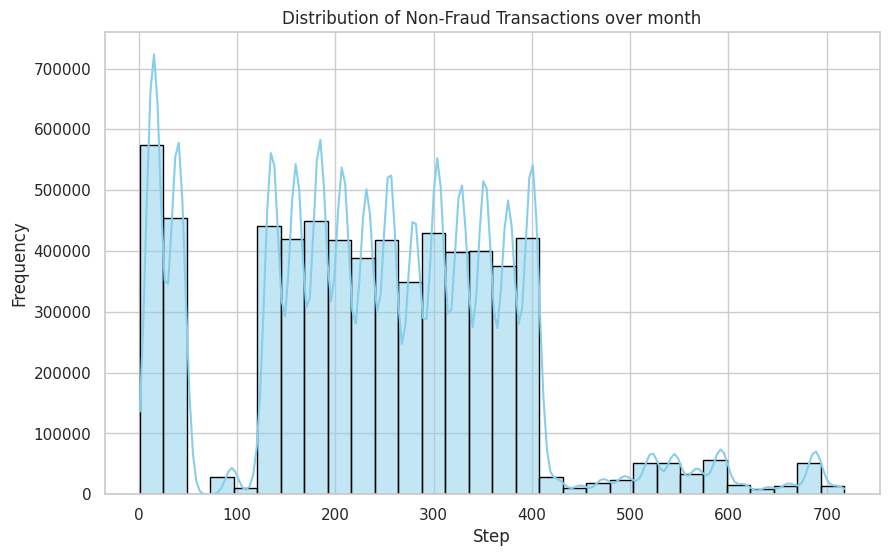

In [24]:
non_fraud_transactions = df[df["isFraud"] == 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_transactions["step"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

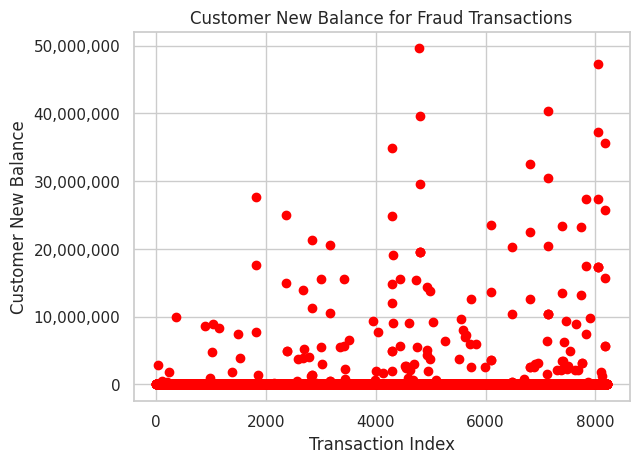

In [25]:
plt.scatter(range(len(fraud_transactions)), fraud_transactions['newbalanceOrg'], color='red')
plt.title('Customer New Balance for Fraud Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Customer New Balance')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))

plt.show()

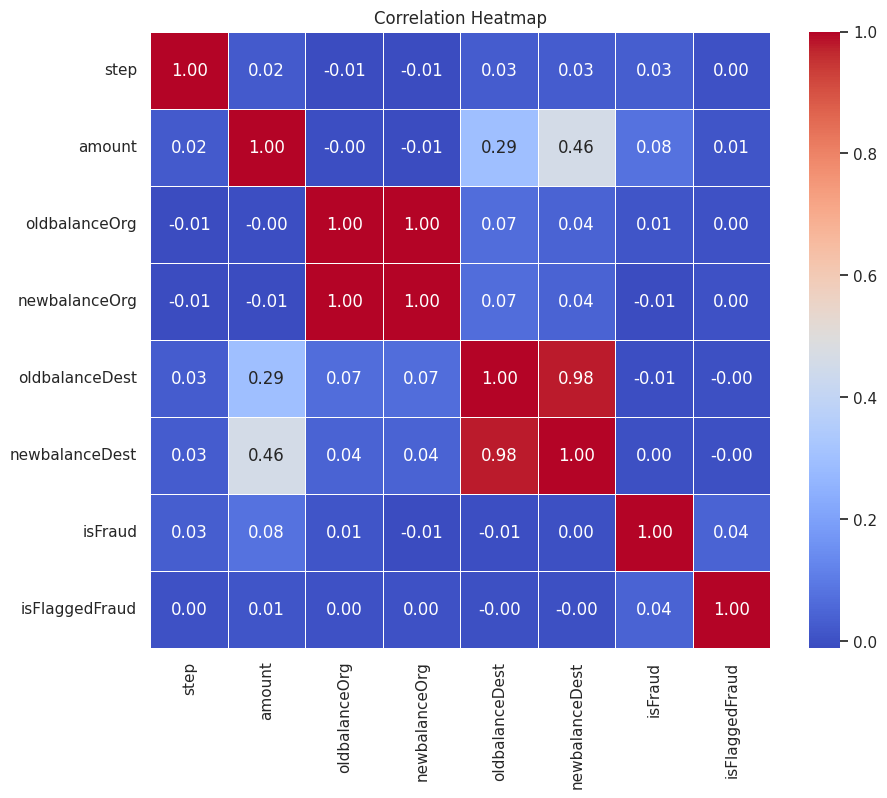

In [26]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# •	Additionally, the following has been done for data cleaning and transformation:
# 	The 'isFlaggedFraud' column has been removed
# 	The transaction types ('CASH_IN', 'DEBIT', 'PAYMENT') has been excluded
# 	Correcting inconsistent balance calculations
# 	Encoding categorical variables
# 	Applying log transformation and robust scaling to numeric features


In [27]:
process_df = df.copy()
process_df.drop('isFlaggedFraud', axis=1, inplace=True)
types_to_exclude = ['CASH_IN', 'DEBIT', 'PAYMENT']
process_df = process_df[~process_df['type'].isin(types_to_exclude)]
print(f"Total count: {process_df.shape[0]}")

Total count: 2770409


In [ ]:
# •	The variables included in the model are: 
# 'step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest'
# •	These variables were selected based on their relevance to detecting fraudulent transactions. They include:
# 	Temporal information (step)
# 	Transaction characteristics (type, amount)
# 	Account balance information before and after the transaction for both origin and destination


In [28]:
total_transactions = len(process_df)
wrong_org_balance = sum(process_df["oldbalanceOrg"] - process_df["amount"] != process_df["newbalanceOrg"])
wrong_dest_balance = sum(process_df["oldbalanceDest"] + process_df["amount"] != process_df["newbalanceDest"])
percentage_wrong_org_balance = (wrong_org_balance / total_transactions) * 100
percentage_wrong_dest_balance = (wrong_dest_balance / total_transactions) * 100

print(f"Percentage of wrong origin balances: {percentage_wrong_org_balance:.2f}%")
print(f"Percentage of wrong destination balances: {percentage_wrong_dest_balance:.2f}%")

Percentage of wrong origin balances: 93.72%
Percentage of wrong destination balances: 42.09%


In [29]:
process_df.loc[ (process_df["oldbalanceOrg"] == 0) | (process_df["oldbalanceOrg"] < process_df["amount"]), "oldbalanceOrg"] = process_df["amount"]
process_df["newbalanceOrg"] = process_df["oldbalanceOrg"] - process_df["amount"]
process_df["newbalanceDest"] = process_df["oldbalanceDest"] + process_df["amount"]

In [30]:
process_df['isCustomerToCustomer'] = ((process_df['nameOrg'].str.startswith('C').astype(int) == 1) & (process_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)

In [31]:
# Count rows where isCustomerToCustomer is 1 for each category of isFraud
count_by_fraud_customer_to_customer = process_df[process_df['isCustomerToCustomer'] == 1].groupby('isFraud').size()

print("Count of rows with isCustomerToCustomer = 1 by isFraud category:")
print(count_by_fraud_customer_to_customer)
print(f"Total count: {count_by_fraud_customer_to_customer.sum()}")


Count of rows with isCustomerToCustomer = 1 by isFraud category:
isFraud
0    2762196
1       8213
dtype: int64
Total count: 2770409


In [ ]:
# •	The 'nameOrg' and 'nameDest' columns were dropped to avoid overfitting to specific account identifiers.

In [32]:
process_df.drop(columns=['nameDest', 'nameOrg'], axis=1, inplace=True)

In [33]:
label_encoder = LabelEncoder()
process_df['type'] = label_encoder.fit_transform(process_df['type'])

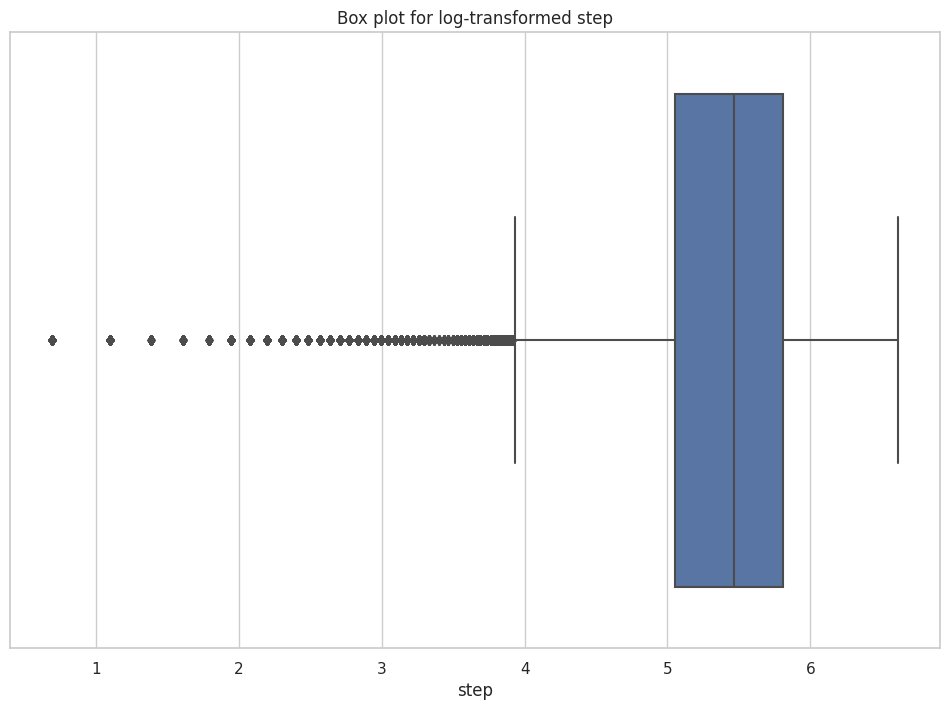

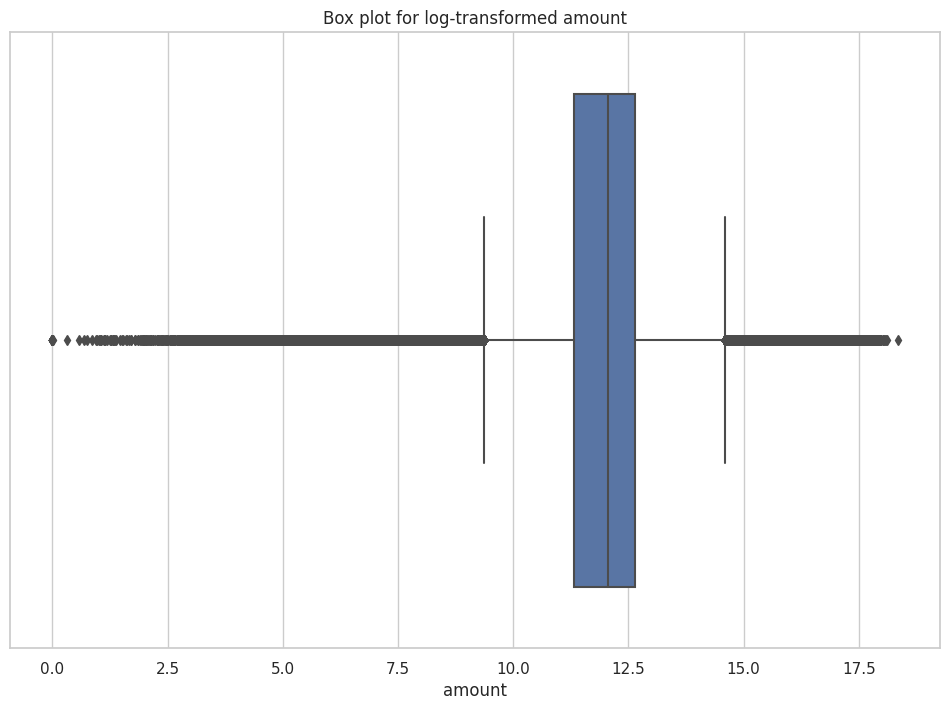

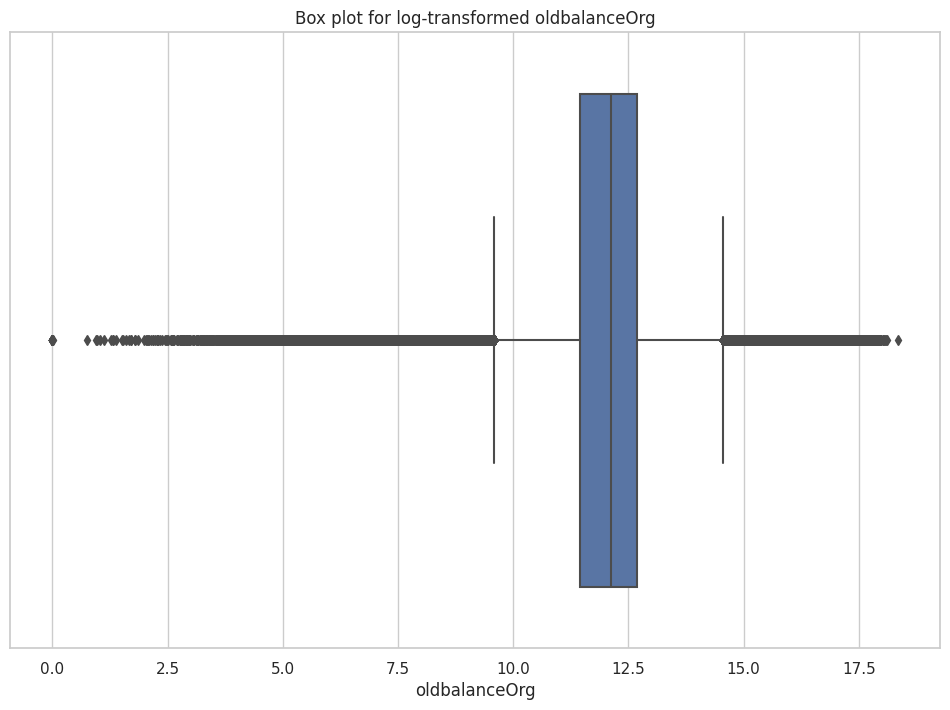

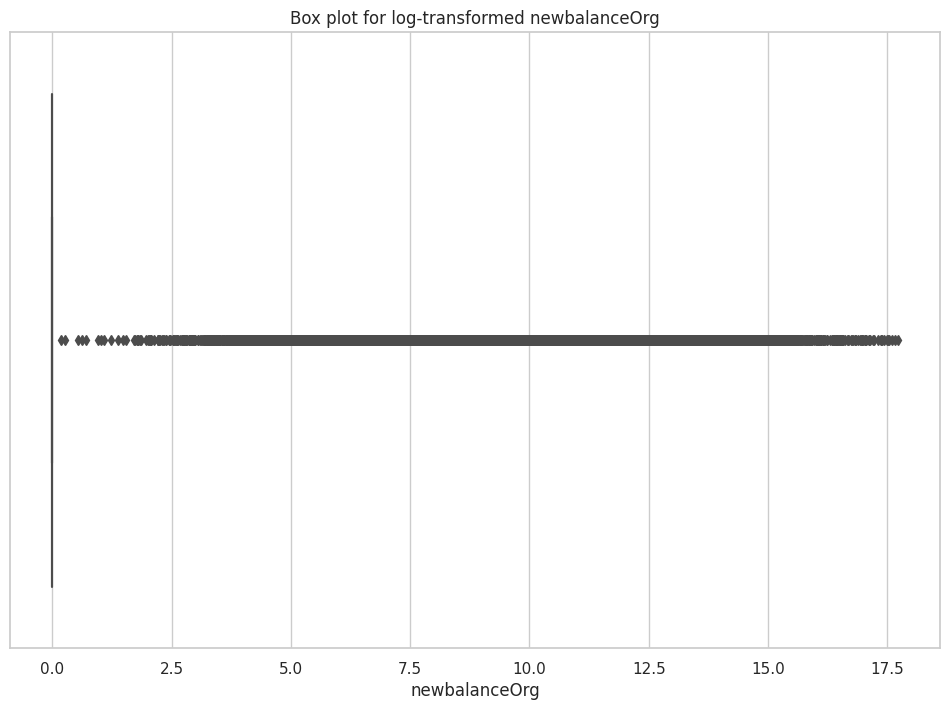

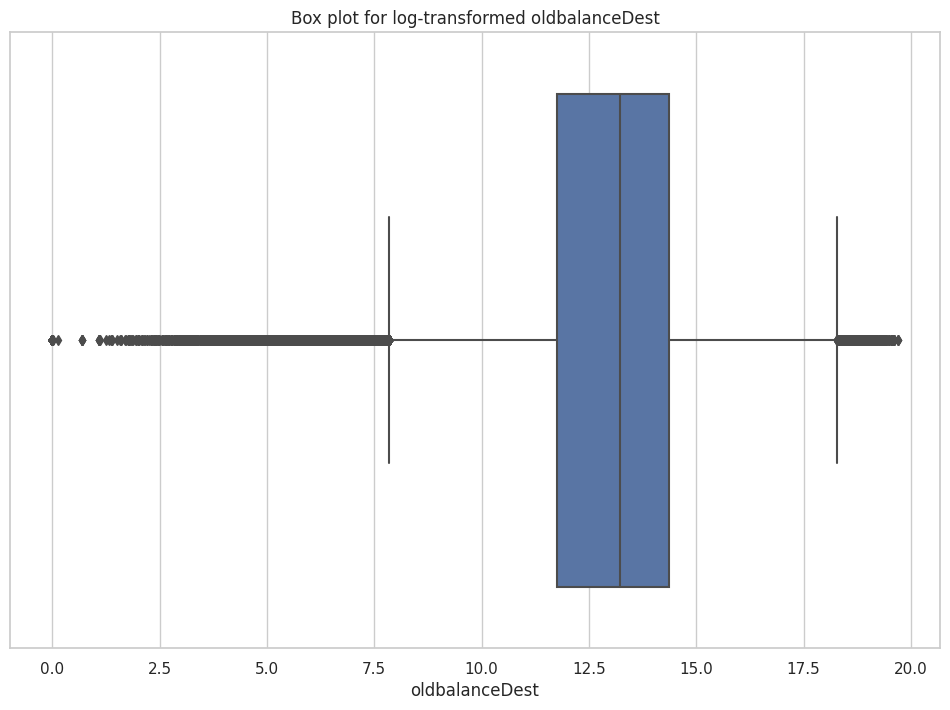

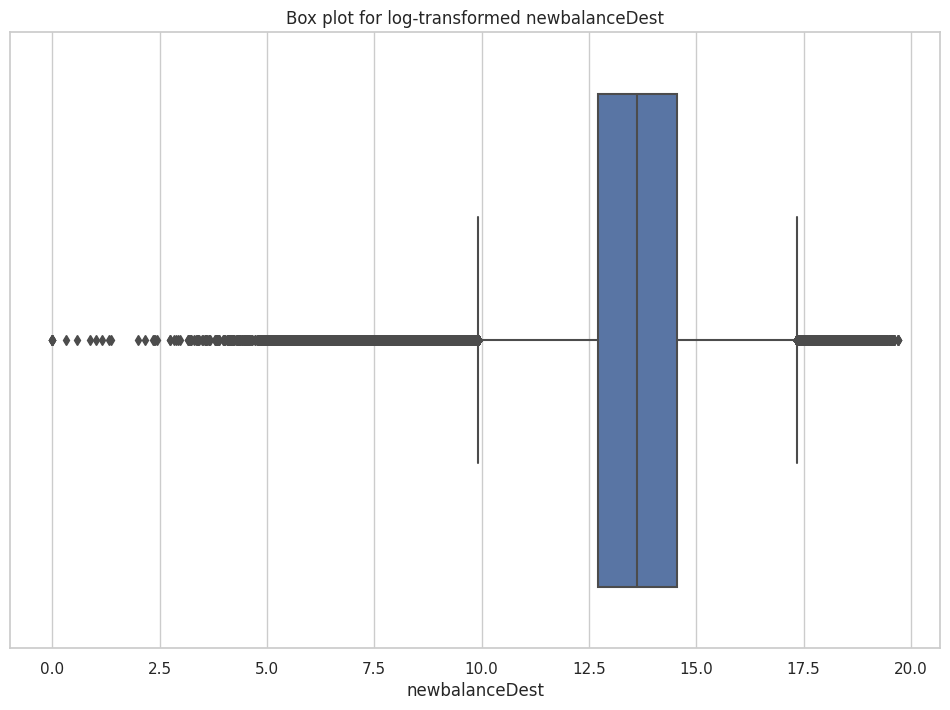

In [34]:
numeric_columns = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']

for column in numeric_columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=np.log1p(process_df[column]))  # Applying log transformation
    plt.title(f'Box plot for log-transformed {column}')
    plt.show()

In [35]:
for column in numeric_columns:
    column_data = process_df[column]
    column_iqr = iqr(column_data)
    print(f"IQR for {column}: {column_iqr}")

IQR for step: 177.0
IQR for amount: 223817.64
IQR for oldbalanceOrg: 231324.15999999997
IQR for newbalanceOrg: 0.0
IQR for oldbalanceDest: 1607826.7
IQR for newbalanceDest: 1765652.54


In [36]:
for column in numeric_columns:
    process_df[column] = np.log1p(process_df[column])

robust_scaler = RobustScaler()
process_df[numeric_columns] = robust_scaler.fit_transform(process_df[numeric_columns])

In [ ]:
# •	The model used for fraud detection is XGBoost (eXtreme Gradient Boosting), an advanced implementation of gradient boosting. The model is optimized using RandomizedSearchCV with stratified 5-fold cross-validation.
# •	The model is trained to predict the 'isFraud' target variable based on features like transaction step, type, amount, and account balances.



# •	Core Principles of XGBoost:
# 	Regularization: XGBoost incorporates regularization techniques to prevent overfitting, a common issue in machine learning models. This helps ensure that the model generalizes well to unseen data.
# 	Scalability: XGBoost is highly scalable, capable of handling large datasets and complex problems efficiently. It can be parallelized across multiple machines, making it suitable for large-scale machine learning applications.
# •	Benefits of Using XGBoost:
# 	High Predictive Accuracy: XGBoost is known for its ability to achieve high predictive accuracy on a wide range of classification and regression tasks.
# 	Robustness to Noise and Outliers: XGBoost's regularization techniques and tree ensemble approach make it less susceptible to noise and outliers in the data.
# 	Scalability and Efficiency: XGBoost can efficiently handle large datasets and complex problems, making it suitable for large-scale machine learning applications.


In [37]:
X = process_df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']]
Y = process_df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [38]:
process_df.drop('isCustomerToCustomer', axis=1, inplace=True)

In [39]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1] 
}

scoring = {
    'f1': make_scorer(f1_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

# Fit the model to your training data
random_search_xgb.fit(X_train, Y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                   param_distributions={'alpha': [0, 0.1, 0.5, 1],
                                        'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                                        'lambda': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 250, 300,
                                                         350],
                                        'scale_pos_weight': [1, 5, 10, 15],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)})

In [41]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search_xgb.best_params_)

Best Hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 0, 'gamma': 1, 'colsample_bytree': 0.8, 'alpha': 1}


In [42]:
    best_xgb_model = xgb.XGBClassifier(**random_search_xgb.best_params_, random_state=42)
    best_xgb_model.fit(X_train, Y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=0.3,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, ...)

In [ ]:
# •	The model's performance is evaluated using several metrics providing a comprehensive view of the model's performance, considering both the accuracy and the balance between different types of errors :
# 	Classification Report: Provides precision, recall, and F1-score for each class
# 	Matthews Correlation Coefficient (MCC): A balanced measure for binary classification
# 	ROC-AUC Score: Measures the model's ability to distinguish between classes
# 	Confusion Matrix: Visualizes true positives, false positives, true negatives, and false negatives


In [43]:
y_pred = best_xgb_model.predict(X_test)
predicted_probabilities = best_xgb_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {f1_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.49      0.55      0.52      1643

    accuracy                           1.00    554082
   macro avg       0.75      0.77      0.76    554082
weighted avg       1.00      1.00      1.00    554082

Matthews Correlation Coefficient: 0.52
ROC-AUC Score: 0.97


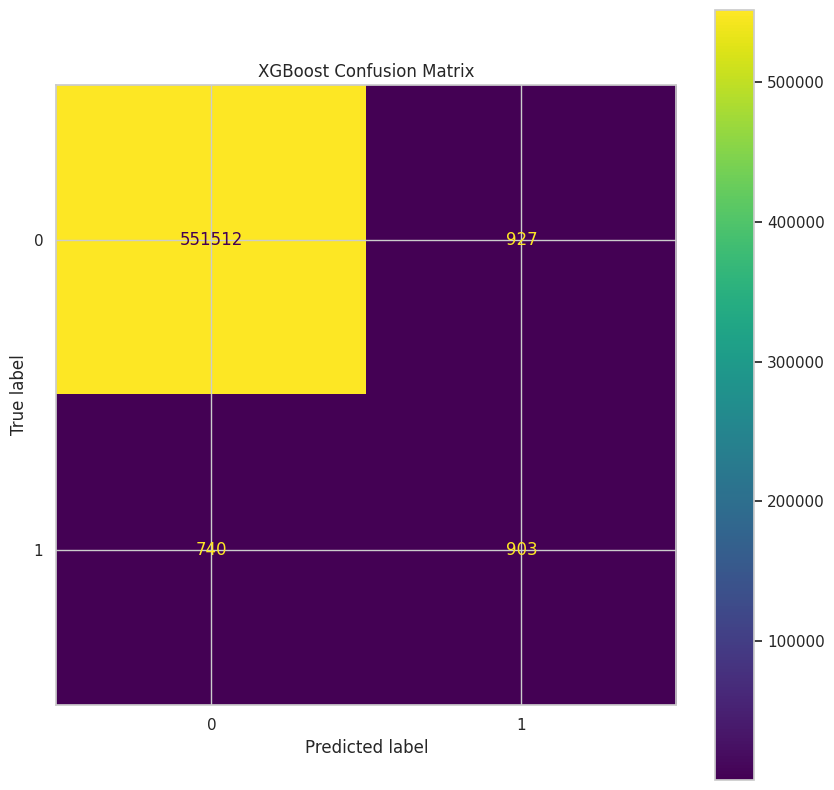

In [44]:
# Assuming Y_test and y_pred are already defined
cm = confusion_matrix(Y_test, y_pred)

# Create the confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.title('XGBoost Confusion Matrix')
plt.show()

In [ ]:
# •	Based on the features we can infer that the following factors are important in predicting fraudulent transactions:
# 	Transaction type
# 	Transaction amount
# 	Discrepancies in account balances before and after transactions
# 	Whether the transaction is between two customers (isCustomerToCustomer)
# •	The correct choice of ML model also plays a crucial role. Following are the factors I chose XGBoost model:
# 	Higher Precision and Recall: The XGBoost model excels in precision (20%) and recall (72%) for identifying fraudulent transactions.
# 	Balanced F1-Score: Achieving an F1-score of 31%, the XGBoost model strikes a balance between precision and recall, ensuring robust performance in fraud detection.
# 	High Accuracy: The XGBoost model maintains a high accuracy level of 99%, emphasizing its ability to correctly classify both fraudulent and non-fraudulent transactions.


In [ ]:
# •	the above factors make sense for detecting fraudulent transactions:
# 	Transaction type: Certain types of transactions may be more prone to fraud.
# 	Transaction amount: Unusually large transactions might be suspicious.
# 	Account balance discrepancies: Inconsistencies in balances before and after transactions could indicate fraudulent activity.
# 	Customer-to-customer transactions: These might have different fraud patterns compared to other transaction types.


In [ ]:
# Following prevention should be adopted while company update its infrastructure :
# •	Proper Implementation of real-time transaction monitoring using the developed model 
# •	There should be setting up of alerts for high-risk transactions based on the model's predictions 
# •	Enhancing customer verification processes with proper authentication, especially for large or unusual transactions 
# •	Implementing additional security measures for customer-to-customer transactions due to recent frauds committed using deepfake AI voice.
# •	Regularly updating and retraining of model with new data to adapt to evolving fraud patterns 
# •	Implementing a multi-factor authentication system for high-risk transactions


In [ ]:
# Following are the actions through which we can determine if our model and methods works or not :
# •	By monitoring key performance metrics over time (e.g., fraud rate, false positive rate, model accuracy) 
# •	Also Analysing the customer feedback and complaints related to fraud or false positives can help in determining how well the developed model works
# •	Performing regular audits of flagged transactions can ensure that the model is catching actual fraud cases or not
# •	By Comparing the financial impact of fraud cases before and after implementing the new measures can play a major role to know how well the ML model works
# •	At last, Continuously updating and retraining the model can help in evaluating its performance on new data
